In [863]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
#from prophet import Prophet

In [864]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [865]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [866]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [867]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [868]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [869]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [870]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
model_fitted = model.fit(10, method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, Mar, 2025
Time:                     19:49:35
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    5.64722
Nobs:                     195.000    HQIC:                  -4.34150
Log likelihood:          -681.034    FPE:                4.26356e-05
AIC:                     -11.1374    Det(Omega_mle):     6.79045e-07
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap              -1.592051         0.537397           -2.963           0.003
L1.Hoyre           -1.490379         0.539932           -2.760           0.006
L1.Frp             -1.694446         0.543085           -3.120         

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [871]:
model_fitted.forecast_cov()

array([[[ 2.14669327e+00, -9.09785721e-01, -4.92126624e-01,
         -1.39856378e-01, -1.98671932e-01, -1.20206413e-02,
         -1.49563957e-01, -2.82322516e-02, -1.76076522e-01,
         -2.59492620e-02],
        [-9.09785721e-01,  1.61984571e+00, -3.87385990e-01,
         -2.92420982e-02, -2.90225558e-01, -4.65895217e-02,
         -8.88035166e-04, -5.04352928e-02,  8.85012262e-02,
          2.55586768e-02],
        [-4.92126624e-01, -3.87385990e-01,  1.29266349e+00,
          1.06128336e-02, -1.03549448e-01, -8.49570865e-02,
         -7.21884770e-02, -2.30757531e-02, -8.18374493e-02,
         -6.23073929e-02],
        [-1.39856378e-01, -2.92420982e-02,  1.06128336e-02,
          1.82161298e-01, -5.75647625e-02,  3.24643319e-03,
          2.47345532e-02, -7.42505374e-03, -1.60756728e-02,
          2.33180222e-02],
        [-1.98671932e-01, -2.90225558e-01, -1.03549448e-01,
         -5.75647625e-02,  8.41591026e-01, -3.00424791e-02,
         -2.77700981e-02, -3.38384906e-02,  4.575497

In [872]:
steps = 8  # Number of steps to forecast
alpha = 0.5

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-02-28", periods=steps, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [873]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


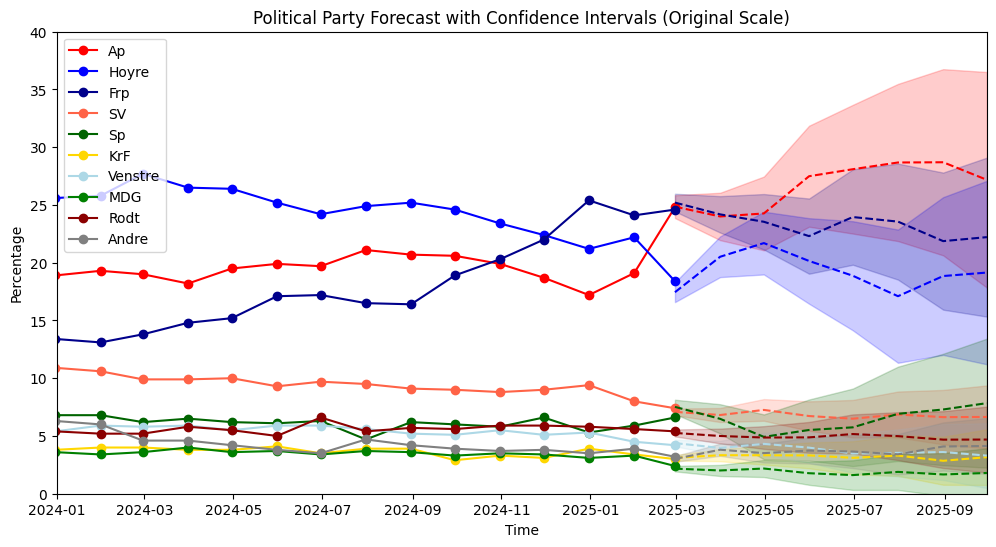

In [874]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)

plt.xlim(np.datetime64("2024-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast with Confidence Intervals (Original Scale)")
plt.legend(loc="upper left")
plt.show()

In [875]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,24.855591,17.447363,25.206267,7.085370,7.518850,3.110415,4.383008,2.171217,5.262956,3.012713
2025-03-31,24.004470,20.517043,24.186049,6.814252,6.484430,3.334868,3.960295,2.013044,4.997798,3.808417
2025-04-30,24.266597,21.700391,23.544688,7.256159,4.922843,3.330570,4.316357,2.181250,4.864731,3.516116
2025-05-31,27.489000,20.151852,22.303631,6.725976,5.519081,3.318372,3.989983,1.775397,4.879423,3.735195
2025-06-30,28.095430,18.872080,23.955420,6.493965,5.747089,3.106760,3.483614,1.612118,5.167638,3.651390
2025-07-31,28.677630,17.101674,23.558824,6.862006,6.917274,3.300551,3.536006,1.890557,4.984995,3.412041
2025-08-31,28.698343,18.846755,21.869915,6.630902,7.293204,2.852084,3.608749,1.667338,4.682685,4.089663
2025-09-30,27.175970,19.148029,22.216184,6.646659,7.843152,3.167490,3.299618,1.797372,4.690177,4.133537


In [876]:
forecast_lower_original_scale


,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,23.867356,16.588919,24.439403,6.797495,6.900084,2.871315,4.102140,1.934122,4.962630,2.763111
2025-03-31,21.952249,18.753626,22.609297,6.206507,5.218737,2.814138,3.344345,1.530518,4.359896,3.281230
2025-04-30,21.073783,18.982493,21.142286,6.317848,2.982020,2.518709,3.355676,1.442075,3.880483,2.700790
2025-05-31,23.117467,16.448650,19.047597,5.452870,2.880594,2.197990,2.677145,0.768760,3.544795,2.612724
2025-06-30,22.522965,14.149961,19.825327,4.870393,2.391960,1.672840,1.810251,0.329551,3.468853,2.216173
2025-07-31,21.873144,11.334704,18.537743,4.875335,2.833666,1.546284,1.495091,0.326447,2.910559,1.658528
2025-08-31,20.637281,12.017155,15.934883,4.276348,2.469388,0.774245,1.188313,-0.182417,2.221563,2.005351
2025-09-30,17.841840,11.203259,15.332756,3.918968,2.256936,0.755905,0.493801,-0.342705,1.838343,1.710221


In [877]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,25.843827,18.305808,25.973130,7.373244,8.137615,3.349515,4.663877,2.408311,5.563282,3.262316
2025-03-31,26.056691,22.280460,25.762801,7.421996,7.750123,3.855598,4.576246,2.495569,5.635699,4.335603
2025-04-30,27.459411,24.418288,25.947090,8.194469,6.863666,4.142431,5.277038,2.920425,5.848978,4.331442
2025-05-31,31.860533,23.855054,25.559664,7.999082,8.157568,4.438753,5.302821,2.782034,6.214052,4.857667
2025-06-30,33.667895,23.594198,28.085514,8.117538,9.102218,4.540679,5.156976,2.894685,6.866424,5.086608
2025-07-31,35.482116,22.868643,28.579906,8.848677,11.000881,5.054818,5.576922,3.454666,7.059430,5.165554
2025-08-31,36.759405,25.676355,27.804946,8.985456,12.117021,4.929924,6.029186,3.517093,7.143808,6.173975
2025-09-30,36.510100,27.092800,29.099612,9.374350,13.429367,5.579074,6.105434,3.937449,7.542012,6.556854


In [878]:
# Example: Your existing dataframes (assuming they have the same index and columns)
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  27.175970  17.841840  36.510100
1    Hoyre  19.148029  11.203259  27.092800
2      Frp  22.216184  15.332756  29.099612
3       SV   6.646659   3.918968   9.374350
4       Sp   7.843152   2.256936  13.429367
5      KrF   3.167490   0.755905   5.579074
6  Venstre   3.299618   0.493801   6.105434
7      MDG   1.797372  -0.342705   3.937449
8     Rodt   4.690177   1.838343   7.542012
9    Andre   4.133537   1.710221   6.556854


In [879]:
# Antall simuleringar
n_sim = 10000

# Trekke stemmer frå normalfordeling
red_green_votes = np.zeros(n_sim)
blue_votes = np.zeros(n_sim)

# Iterate over the result_df DataFrame
for _, row in result_df.iterrows():
    party = row["Party"]
    yhat = row["Estimate"]
    lower = row["Lower"]
    upper = row["Upper"]

    z_alpha_half = norm.ppf(1 - (1 - alpha) / 2)  # Compute Z-score for given alpha
    factor = 2 * z_alpha_half  # Convert to full interval width
    #print(factor)
    std_dev = (upper - lower) / factor  # Omformar intervall til standardavvik (~50% dekking)
    samples = np.random.normal(yhat, std_dev, n_sim)
    
    if party in ["Ap", "SV", "Sp", "Rodt", "MDG"]:
        red_green_votes += samples
    else:
        blue_votes += samples

# Sannsyn for at den raudgrøne blokka er større
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.4323


In [880]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,24.855591,17.447363,25.206267,7.085370,7.518850,3.110415,4.383008,2.171217,5.262956,3.012713
2025-03-31,24.004470,20.517043,24.186049,6.814252,6.484430,3.334868,3.960295,2.013044,4.997798,3.808417
2025-04-30,24.266597,21.700391,23.544688,7.256159,4.922843,3.330570,4.316357,2.181250,4.864731,3.516116
2025-05-31,27.489000,20.151852,22.303631,6.725976,5.519081,3.318372,3.989983,1.775397,4.879423,3.735195
2025-06-30,28.095430,18.872080,23.955420,6.493965,5.747089,3.106760,3.483614,1.612118,5.167638,3.651390
2025-07-31,28.677630,17.101674,23.558824,6.862006,6.917274,3.300551,3.536006,1.890557,4.984995,3.412041
2025-08-31,28.698343,18.846755,21.869915,6.630902,7.293204,2.852084,3.608749,1.667338,4.682685,4.089663
2025-09-30,27.175970,19.148029,22.216184,6.646659,7.843152,3.167490,3.299618,1.797372,4.690177,4.133537


In [881]:
# Number of simulations
n_sim = 100000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[0]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.5433


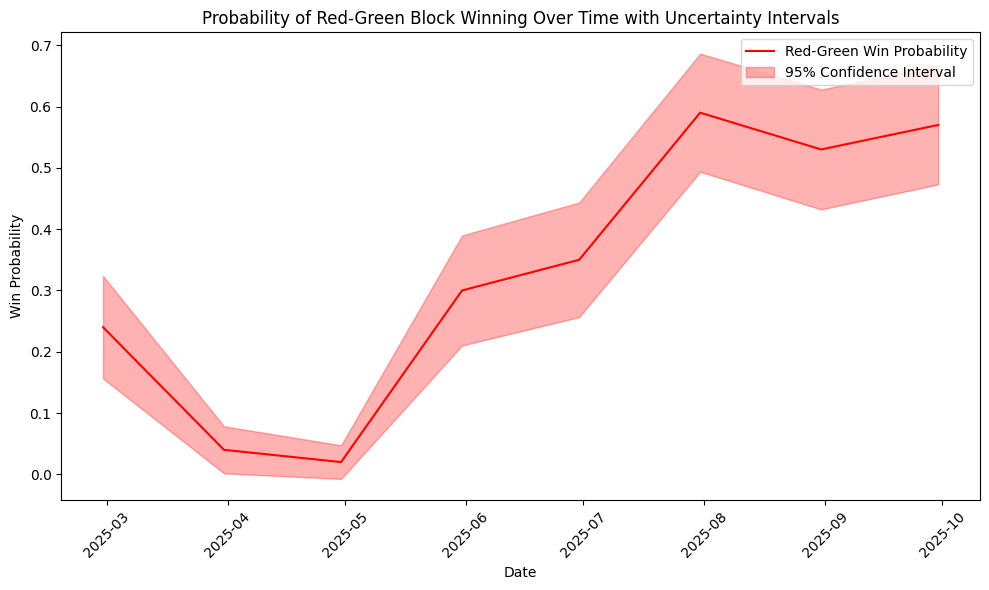

In [882]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Number of simulations
n_sim = 100

# Party groupings for Red-Green and Blue blocks
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Create empty lists to store results over time
prob_red_green_wins_over_time = []
lower_bound_over_time = []
upper_bound_over_time = []

# Loop over each forecast step (time period)
for step in range(len(forecast_original_scale)):
    # Extract mean estimates (yhat) and covariance matrix for the current time step
    yhat_vector = forecast_original_scale.iloc[step].values  # Mean estimates for all parties
    cov_matrix = forecast_cov_original_scale[step]  # Covariance matrix at the current step

    # Generate correlated samples using the multivariate normal distribution
    samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)

    # Create a DataFrame with sampled values
    sampled_df = pd.DataFrame(samples, columns=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'])

    # Compute vote totals for each simulation
    red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
    blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

    # Compute win probability as the proportion of red-green wins
    win_indicator = (red_green_votes > blue_votes).astype(int)  # 1 if red-green block wins, 0 if not

    # Calculate the binomial confidence interval using binom.interval
    p_hat = np.mean(win_indicator)  # Proportion of wins
    lower_bound, upper_bound = stats.binom.interval(0.95, np.sqrt(n_sim), p_hat)  # 95% confidence interval

    mu = p_hat * n_sim  # mean
    sigma = np.sqrt(n_sim * p_hat * (1 - p_hat))  # standard deviation
    z_alpha_half = stats.norm.ppf(1 - 0.025)  # 1.96 for a 95% confidence level

    # Compute lower and upper bounds using the normal approximation
    lower_bound = mu - z_alpha_half * sigma
    upper_bound = mu + z_alpha_half * sigma

    # Normalize the bounds to proportions
    lower_bound = lower_bound / n_sim
    upper_bound = upper_bound / n_sim

    # Store the results
    prob_red_green_wins_over_time.append(p_hat)
    lower_bound_over_time.append(lower_bound)
    upper_bound_over_time.append(upper_bound)

# Create a DataFrame to hold the probabilities over time
forecast_dates = forecast_original_scale.index
prob_red_green_wins_df = pd.DataFrame({
    "Red-Green Win Probability": prob_red_green_wins_over_time,
    "Lower Bound (95%)": lower_bound_over_time,
    "Upper Bound (95%)": upper_bound_over_time
}, index=forecast_dates)

# Plot the probability of red-green block winning with uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(prob_red_green_wins_df.index, prob_red_green_wins_df["Red-Green Win Probability"], label="Red-Green Win Probability", color="red")
plt.fill_between(prob_red_green_wins_df.index, prob_red_green_wins_df["Lower Bound (95%)"], prob_red_green_wins_df["Upper Bound (95%)"], 
                 color='red', alpha=0.3, label="95% Confidence Interval")
plt.title("Probability of Red-Green Block Winning Over Time with Uncertainty Intervals")
plt.xlabel("Date")
plt.ylabel("Win Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


In [883]:
lower_bound_over_time

[0.15629324466361103,
 0.0015927065891575244,
 -0.007439495783560757,
 0.21018316681457946,
 0.2565156760890943,
 0.4936024435617837,
 0.43217835657509596,
 0.47296693568931614]

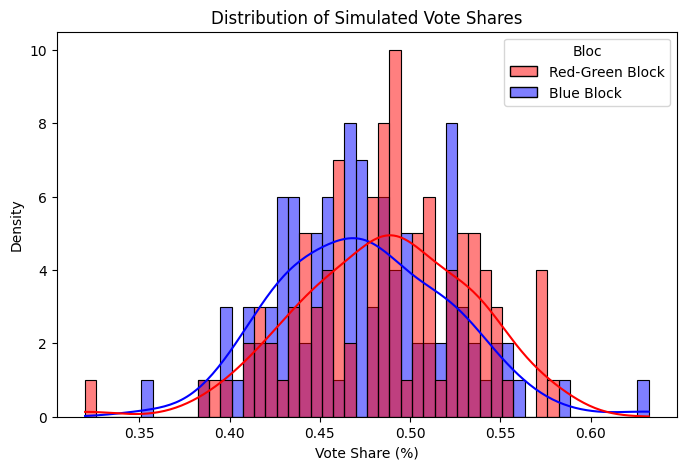

In [884]:

# Create a DataFrame with both red-green and blue votes
df_votes = pd.DataFrame({
    "Red-Green Block": red_green_votes,
    "Blue Block": blue_votes
})

# Melt the DataFrame for easier plotting
df_votes_melted = df_votes.melt(var_name="Bloc", value_name="Votes")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df_votes_melted, x="Votes", hue="Bloc", kde=True, palette={"Red-Green Block": "red", "Blue Block": "blue"}, alpha=0.5, bins=50)
plt.xlabel("Vote Share (%)")
plt.ylabel("Density")
plt.title("Distribution of Simulated Vote Shares")
plt.show()


In [885]:
yhat_vector

array([27.17596977, 19.1480292 , 22.21618406,  6.64665875,  7.84315156,
        3.16748987,  3.29961781,  1.79737241,  4.69017723,  4.13353732])

In [886]:
cov_matrix

array([[ 2.40886505e+01, -1.02152446e+01, -4.81694854e+00,
        -1.97546809e+00, -2.07858752e+00, -6.34471667e-01,
        -1.30163228e+00, -5.14547222e-01, -2.16015210e+00,
        -1.08301446e-01],
       [-1.02152446e+01,  1.74539840e+01, -3.58802396e+00,
        -1.71545638e-01, -2.83259225e+00, -5.58586645e-01,
        -2.77964652e-01, -3.83155392e-01,  5.48759241e-01,
         2.80056320e-02],
       [-4.81694854e+00, -3.58802396e+00,  1.30721223e+01,
         7.83290427e-02, -1.19656078e+00, -7.81087193e-01,
        -1.15338996e+00, -1.93445361e-01, -5.95692382e-01,
        -7.47576134e-01],
       [-1.97546809e+00, -1.71545638e-01,  7.83290427e-02,
         2.05696170e+00, -7.05228060e-01,  2.17698421e-01,
         1.34120898e-01,  6.06774467e-03, -5.85944225e-02,
         3.21895694e-01],
       [-2.07858752e+00, -2.83259225e+00, -1.19656078e+00,
        -7.05228060e-01,  8.61074217e+00, -4.91128471e-01,
        -1.30249943e-01, -2.76480367e-01,  5.71405516e-01,
        -1.

<Axes: >

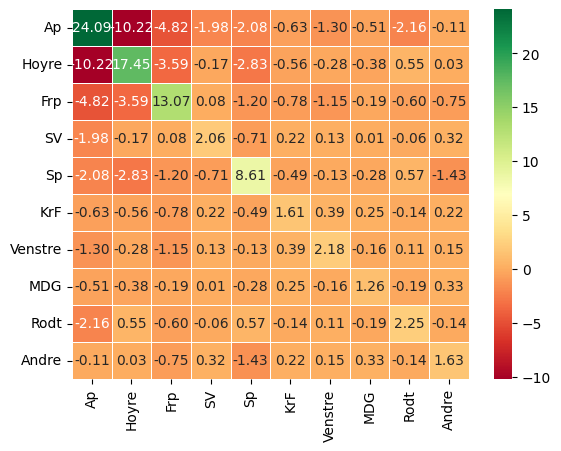

In [887]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
sns.heatmap(cov_matrix, 
            annot=True,        # Show values inside the heatmap
            cmap="RdYlGn",
            fmt=".2f",         # Format values to 2 decimal places
            linewidths=0.5,    # Grid lines
            xticklabels=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'],  # Ensure party names on X-axis
            yticklabels=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre'])    # Ensure party names on Y-axis


In [888]:
# Define party groupings
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Calculate sum columns for each bloc
forecast_original_scale["Red-Green Block"] = forecast_original_scale[red_green_parties].sum(axis=1)
forecast_original_scale["Blue Block"] = forecast_original_scale[blue_parties].sum(axis=1)

# Optionally, preview the updated DataFrame
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre,Red-Green Block,Blue Block
2025-02-28,24.855591,17.447363,25.206267,7.085370,7.518850,3.110415,4.383008,2.171217,5.262956,3.012713,46.893983,50.147054
2025-03-31,24.004470,20.517043,24.186049,6.814252,6.484430,3.334868,3.960295,2.013044,4.997798,3.808417,44.313993,51.998256
2025-04-30,24.266597,21.700391,23.544688,7.256159,4.922843,3.330570,4.316357,2.181250,4.864731,3.516116,43.491580,52.892005
2025-05-31,27.489000,20.151852,22.303631,6.725976,5.519081,3.318372,3.989983,1.775397,4.879423,3.735195,46.388878,49.763838
2025-06-30,28.095430,18.872080,23.955420,6.493965,5.747089,3.106760,3.483614,1.612118,5.167638,3.651390,47.116241,49.417874
2025-07-31,28.677630,17.101674,23.558824,6.862006,6.917274,3.300551,3.536006,1.890557,4.984995,3.412041,49.332461,47.497056
2025-08-31,28.698343,18.846755,21.869915,6.630902,7.293204,2.852084,3.608749,1.667338,4.682685,4.089663,48.972472,47.177503
2025-09-30,27.175970,19.148029,22.216184,6.646659,7.843152,3.167490,3.299618,1.797372,4.690177,4.133537,48.153330,47.831321


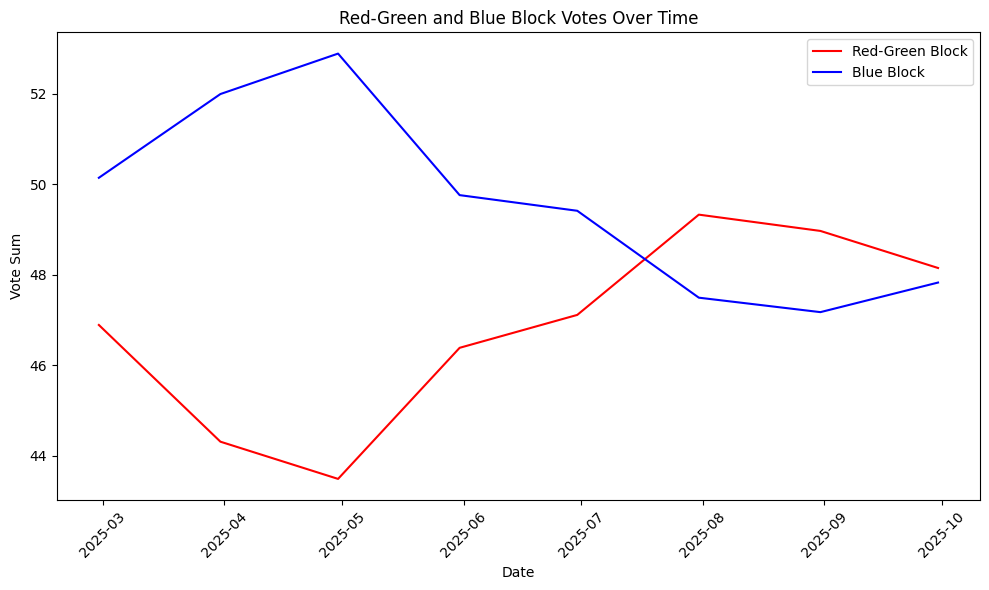

In [889]:
# Plot the red-green and blue block time series
plt.figure(figsize=(10, 6))

# Plot Red-Green Block
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="Red-Green Block", color="red")

# Plot Blue Block
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="Blue Block", color="blue")

# Customize the plot
plt.title('Red-Green and Blue Block Votes Over Time')
plt.xlabel('Date')
plt.ylabel('Vote Sum')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
